In [61]:
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torch.autograd import Variable

In [62]:
# Downloading and Loading Dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transforms.ToTensor(),download=True)
 
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transforms.ToTensor())

In [63]:
# Fitting data loaders for iterating
B_SIZE = 256

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=B_SIZE, 
                                           shuffle=True) 
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=B_SIZE,
                                          shuffle=False)
image_size = (28,28)
output_label_size = 10

In [126]:
train_dataset.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [124]:
def imshow(inp, title=None):
#   Imshow for Tensor.
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = np.clip(std * inp + mean, 0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

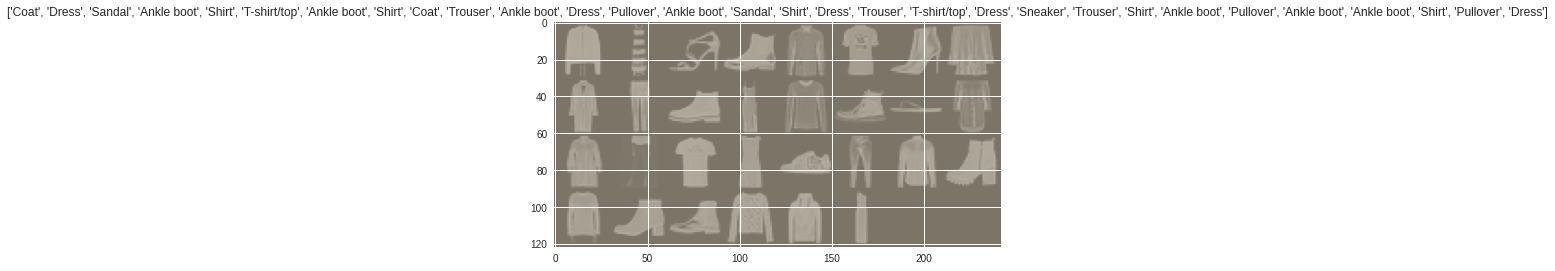

In [131]:

# Visualizing a batch of training data
inputs, classes = next(iter(train_loader))

n_images = 30

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0:n_images])

imshow(out, title=[train_dataset.classes[x] for x in classes[0:n_images]])

In [67]:
def train_epoch(model, train_loader, optimizer, criterion, epoch, device):
    """ Training a model for one epoch """
    
    loss_list = []
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, labels) in progress_bar:
       
        images = images.to(device)
        labels = labels.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        # Forward pass only to get logits/output
        outputs = model(images)
        outputs = outputs.to(device)
         
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
         
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
        
        progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")
        
    mean_loss = np.mean(loss_list)
    return mean_loss, loss_list


@torch.no_grad()
def eval_model(model, eval_loader, criterion, device):
    """ Evaluating the model for either validation or test """
    correct = 0
    total = 0
    loss_list = []
    
    for images, labels in eval_loader:

        images = images.to(device)
        labels = labels.to(device)
        
        
        # Forward pass only to get logits/output
        outputs = model(images)
                 
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
            
        # Get predictions from the maximum value
        preds = torch.argmax(outputs, dim=1)
        correct += len( torch.where(preds==labels)[0] )
        total += len(labels)
                 
    # Total correct predictions and loss
    accuracy = correct / total * 100
    loss = np.mean(loss_list)
    
    return accuracy, loss


def train_model(model, optimizer, scheduler, criterion, train_loader, valid_loader, num_epochs):
    """ Training a model for a given number of epochs"""
    
    train_loss = []
    val_loss =  []
    loss_iters = []
    valid_acc = []
    epochs = []
    
    for epoch in range(num_epochs):
           
        # validation epoch
        model.eval()  # important for dropout and batch norms
        accuracy, loss = eval_model(
                    model=model, eval_loader=valid_loader,
                    criterion=criterion, device=device
            )
        valid_acc.append(accuracy)
        val_loss.append(loss)
        epochs.append(epoch+1)
        
        # training epoch
        model.train()  # important for dropout and batch norms
        mean_loss, cur_loss_iters = train_epoch(
                model=model, train_loader=train_loader, optimizer=optimizer,
                criterion=criterion, epoch=epoch, device=device
            )
        scheduler.step()
        train_loss.append(mean_loss)
        loss_iters = loss_iters + cur_loss_iters
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"    Train loss: {round(mean_loss, 5)}")
        print(f"    Valid loss: {round(loss, 5)}")
        print(f"    Accuracy: {accuracy}%")
        print("\n")
    
    print(f"Training completed")
    return train_loss, val_loss, loss_iters, valid_acc, epochs


def count_model_params(model):
    """ Counting the number of learnable parameters in a nn.Module """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params

### Implementing PyTorch LSTM model (using nn.LSTM)

In [71]:
class torch_LSTM(nn.Module):
    def __init__(self, input_dims, emd_dim, hidden_dim, num_layers, mode):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.mode = mode
        
        self.encoder = nn.Linear(in_features=input_dims, out_features=emd_dim)
        self.lstm = nn.LSTM(input_size=emd_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.classifier = nn.Linear(in_features=hidden_dim, out_features=10)
        return
    
    
    def forward(self, x):
        b_size, n_channels, n_rows, n_cols = x.shape
        h,c = self.init_state(b_size=b_size, device=x.device)
        
        x_rowed = x.view(b_size, n_channels*n_rows, n_cols)
        embeddings = self.encoder(x_rowed)
        
        lstm_out , (h_out, c_out) = self.lstm(embeddings, (h,c))
        
        y = self.classifier(lstm_out[:, -1, :])
        
        return y
    
    def init_state(self, b_size, device):
        if(self.mode == "zeros"):
            h = torch.zeros(self.num_layers, b_size, self.hidden_dim)
            c = torch.zeros(self.num_layers, b_size, self.hidden_dim)
        elif(self.mode == "random"):
            h = torch.randn(self.num_layers, b_size, self.hidden_dim)
            c = torch.randn(self.num_layers, b_size, self.hidden_dim)
        elif(self.mode == "learned"):
            h = self.learned_h.repeat(1, b_size, 1)
            c = self.learned_c.repeat(1, b_size, 1)
        h = h.to(device)
        c = c.to(device)
        return h, c

In [72]:
model_torch = torch_LSTM(input_dims=28, emd_dim=64, hidden_dim=128, num_layers=1 , mode="zeros")
model_torch=model_torch.to(device)
print(model_torch)

torch_LSTM(
  (encoder): Linear(in_features=28, out_features=64, bias=True)
  (lstm): LSTM(64, 128, batch_first=True)
  (classifier): Linear(in_features=128, out_features=10, bias=True)
)


In [73]:
# classification loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model_torch.parameters(), lr=3e-4)

# Decay LR by a factor of 0.1 every 5 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)

In [74]:
train_loss_lstm, val_loss_lstm, loss_iters_lstm, valid_acc_lstm, epochs_lstm = train_model(
        model=model_torch, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=test_loader, num_epochs=20
    )

Epoch 1 Iter 235: loss 0.58300. : 100%|██████████| 235/235 [00:12<00:00, 18.25it/s]


Epoch 1/20
    Train loss: 1.26944
    Valid loss: 2.30314
    Accuracy: 12.31%




Epoch 2 Iter 235: loss 0.47552. : 100%|██████████| 235/235 [00:12<00:00, 18.31it/s]


Epoch 2/20
    Train loss: 0.61194
    Valid loss: 0.71484
    Accuracy: 73.3%




Epoch 3 Iter 235: loss 0.56692. : 100%|██████████| 235/235 [00:13<00:00, 17.92it/s]


Epoch 3/20
    Train loss: 0.52085
    Valid loss: 0.56789
    Accuracy: 78.81%




Epoch 4 Iter 235: loss 0.50416. : 100%|██████████| 235/235 [00:13<00:00, 17.98it/s]


Epoch 4/20
    Train loss: 0.47674
    Valid loss: 0.5191
    Accuracy: 80.74%




Epoch 5 Iter 235: loss 0.41211. : 100%|██████████| 235/235 [00:12<00:00, 18.39it/s]


Epoch 5/20
    Train loss: 0.44187
    Valid loss: 0.46481
    Accuracy: 83.11%




Epoch 6 Iter 235: loss 0.37002. : 100%|██████████| 235/235 [00:12<00:00, 18.45it/s]


Epoch 6/20
    Train loss: 0.40579
    Valid loss: 0.46382
    Accuracy: 82.80999999999999%




Epoch 7 Iter 235: loss 0.31312. : 100%|██████████| 235/235 [00:13<00:00, 17.94it/s]


Epoch 7/20
    Train loss: 0.39654
    Valid loss: 0.42406
    Accuracy: 84.19%




Epoch 8 Iter 235: loss 0.41327. : 100%|██████████| 235/235 [00:12<00:00, 18.32it/s]


Epoch 8/20
    Train loss: 0.39241
    Valid loss: 0.4177
    Accuracy: 84.49%




Epoch 9 Iter 235: loss 0.40986. : 100%|██████████| 235/235 [00:12<00:00, 18.28it/s]


Epoch 9/20
    Train loss: 0.38823
    Valid loss: 0.41518
    Accuracy: 84.78%




Epoch 10 Iter 235: loss 0.34047. : 100%|██████████| 235/235 [00:12<00:00, 18.31it/s]


Epoch 10/20
    Train loss: 0.38261
    Valid loss: 0.41394
    Accuracy: 84.72%




Epoch 11 Iter 235: loss 0.37628. : 100%|██████████| 235/235 [00:12<00:00, 18.40it/s]


Epoch 11/20
    Train loss: 0.37466
    Valid loss: 0.40825
    Accuracy: 84.77%




Epoch 12 Iter 235: loss 0.26027. : 100%|██████████| 235/235 [00:12<00:00, 18.30it/s]


Epoch 12/20
    Train loss: 0.37285
    Valid loss: 0.40416
    Accuracy: 84.99%




Epoch 13 Iter 235: loss 0.30169. : 100%|██████████| 235/235 [00:12<00:00, 18.52it/s]


Epoch 13/20
    Train loss: 0.37224
    Valid loss: 0.40391
    Accuracy: 85.18%




Epoch 14 Iter 235: loss 0.25214. : 100%|██████████| 235/235 [00:12<00:00, 18.17it/s]


Epoch 14/20
    Train loss: 0.37099
    Valid loss: 0.40272
    Accuracy: 85.13%




Epoch 15 Iter 235: loss 0.38401. : 100%|██████████| 235/235 [00:12<00:00, 18.22it/s]


Epoch 15/20
    Train loss: 0.37067
    Valid loss: 0.4027
    Accuracy: 85.05%




Epoch 16 Iter 235: loss 0.43880. : 100%|██████████| 235/235 [00:12<00:00, 18.53it/s]


Epoch 16/20
    Train loss: 0.36903
    Valid loss: 0.40379
    Accuracy: 84.88%




Epoch 17 Iter 235: loss 0.30831. : 100%|██████████| 235/235 [00:12<00:00, 18.60it/s]


Epoch 17/20
    Train loss: 0.36828
    Valid loss: 0.4012
    Accuracy: 85.00999999999999%




Epoch 18 Iter 235: loss 0.44818. : 100%|██████████| 235/235 [00:12<00:00, 18.47it/s]


Epoch 18/20
    Train loss: 0.36844
    Valid loss: 0.40114
    Accuracy: 85.13%




Epoch 19 Iter 235: loss 0.29129. : 100%|██████████| 235/235 [00:12<00:00, 18.30it/s]


Epoch 19/20
    Train loss: 0.36781
    Valid loss: 0.4009
    Accuracy: 85.05%




Epoch 20 Iter 235: loss 0.41187. : 100%|██████████| 235/235 [00:12<00:00, 18.18it/s]

Epoch 20/20
    Train loss: 0.368
    Valid loss: 0.40105
    Accuracy: 85.05%


Training completed


### Implementing own custom LSTM model without using nn.LSTM

In [75]:
class LSTM_Cells(torch.nn.Module):
   
    def __init__(self, in_dim, hidden_dim, bias=True):
        super(LSTM_Cells, self).__init__()
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.bias = bias
        self.layer1 = nn.Linear(in_dim, 4 * hidden_dim, bias=bias)
        self.layer2 = nn.Linear(hidden_dim, 4 * hidden_dim, bias=bias)
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_dim)
        for w in self.parameters():
            w.data.uniform_(-std, std)
    
    def forward(self, x, hidden):
        
        x = x.view(-1, x.size(1))
        hx, cx = hidden
        
        gates = self.layer1(x) + self.layer2(hx)
        gates = gates.squeeze()
        
        input_gate, forget_gate, next_gate, out_gate = gates.chunk(4, 1)
        
        input_gate = torch.sigmoid(input_gate)
        
        forget_gate = torch.sigmoid(forget_gate)
        
        next_gate = torch.tanh(next_gate)
        
        out_gate = torch.sigmoid(out_gate)  
        
        c_y = forget_gate * cx + input_gate * next_gate
        h_y = out_gate * torch.tanh(c_y)
        
        return (c_y, h_y)
class Custom_LSTM(nn.Module):
    """ 
    Custom LSTM for images. Embedded image rows are fed to a RNN
    
    Args:
    -----
    input_dim: integer
        dimensionality of the rows to embed
    emb_dim: integer 
        dimensionality of the vectors fed to the LSTM
    hidden_dim: integer
        dimensionality of the states in the cell
    num_layers: integer
        number of stacked LSTMS
    mode: string
        intialization of the states
    """
    
    def __init__(self, input_dim, emb_dim, hidden_dim, num_layers=1, mode="zeros"):
        """ Module initializer """
        assert mode in ["zeros", "random", "learned"]
        super().__init__()
        self.hidden_dim =  hidden_dim
        self.input_dim =  input_dim
        self.num_layers = num_layers
        self.mode = mode
        if(mode == "learned"):
            self.learned_h = nn.Parameter(
                    torch.randn(num_layers, 1, hidden_dim).requires_grad_()
                )
            self.learned_c = nn.Parameter(
                    torch.randn(num_layers, 1, hidden_dim).requires_grad_()
                )
        
        # for embedding rows into vector representations
        self.encoder = nn.Linear(in_features=input_dim, out_features=emb_dim)

        lstms = []
        for i in range(num_layers):
            in_size = emb_dim if i == 0 else hidden_dim
            lstms.append(LSTM_Cells(in_dim=in_size, hidden_dim=hidden_dim))
        self.lstm = nn.ModuleList(lstms)
        
        # classifier
        self.classifier = nn.Linear(in_features=hidden_dim, out_features=10)
        
        return
    

    def forward(self, x):
        """ Forward pass through model """
        
        b_size, n_channels, n_rows, n_cols = x.shape
        h, c = self.init_state(b_size=b_size, device=x.device) 
        
        # embedding rows
        x_rowed = x.view(b_size, n_channels*n_rows, n_cols)

        embeddings = self.encoder(x_rowed)


        lstm_out = []
        for i in range(embeddings.shape[1]):
            lstm_input = embeddings[:, i, :]
            # iterating over LSTM Cells
            for j, lstm_cell in enumerate(self.lstm):
                h[j], c[j] = lstm_cell(lstm_input, (h[j].clone(), c[j].clone()))
                lstm_input = h[j]
            lstm_out.append(lstm_input)
        lstm_out = torch.stack(lstm_out, dim=1)

        # classifying
        y = self.classifier(lstm_out[:, -1, :])  # feeding only output at last layer
        return y
    
        
    def init_state(self, b_size, device):
        """ Initializing hidden and cell state """
        if(self.mode == "zeros"):
            h = torch.zeros(self.num_layers, b_size, self.hidden_dim)
            c = torch.zeros(self.num_layers, b_size, self.hidden_dim)
        elif(self.mode == "random"):
            h = torch.randn(self.num_layers, b_size, self.hidden_dim)
            c = torch.randn(self.num_layers, b_size, self.hidden_dim)
        elif(self.mode == "learned"):
            h = self.learned_h.repeat(1, b_size, 1)
            c = self.learned_c.repeat(1, b_size, 1)
        h = h.to(device)
        c = c.to(device)
        return h, c

In [79]:
model_customlstm = Custom_LSTM(input_dim=28, emb_dim=64, hidden_dim=128, num_layers=1, mode="zeros")
count_model_params(model_customlstm)

102474

In [80]:
model_customlstm = model_customlstm.to(device)
print(model_customlstm)

Custom_LSTM(
  (encoder): Linear(in_features=28, out_features=64, bias=True)
  (lstm): ModuleList(
    (0): LSTM_Cells(
      (layer1): Linear(in_features=64, out_features=512, bias=True)
      (layer2): Linear(in_features=128, out_features=512, bias=True)
    )
  )
  (classifier): Linear(in_features=128, out_features=10, bias=True)
)


In [81]:
# classification loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model_customlstm.parameters(), lr=3e-4)

# Decay LR by a factor of 0.1 every 5 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)

In [82]:
train_loss_cuslstm, val_loss_cuslstm, loss_iters_cuslstm, valid_acc_cuslstm, epochs_cuslstm = train_model(
        model=model_customlstm, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=test_loader, num_epochs=20
    )

Epoch 1 Iter 235: loss 0.85829. : 100%|██████████| 235/235 [00:20<00:00, 11.57it/s]


Epoch 1/20
    Train loss: 1.27751
    Valid loss: 2.30887
    Accuracy: 9.99%




Epoch 2 Iter 235: loss 0.67557. : 100%|██████████| 235/235 [00:20<00:00, 11.59it/s]


Epoch 2/20
    Train loss: 0.65571
    Valid loss: 0.75935
    Accuracy: 72.37%




Epoch 3 Iter 235: loss 0.45347. : 100%|██████████| 235/235 [00:19<00:00, 11.82it/s]


Epoch 3/20
    Train loss: 0.55336
    Valid loss: 0.59242
    Accuracy: 78.63%




Epoch 4 Iter 235: loss 0.47995. : 100%|██████████| 235/235 [00:20<00:00, 11.64it/s]


Epoch 4/20
    Train loss: 0.50555
    Valid loss: 0.54261
    Accuracy: 80.58%




Epoch 5 Iter 235: loss 0.48621. : 100%|██████████| 235/235 [00:20<00:00, 11.61it/s]


Epoch 5/20
    Train loss: 0.47171
    Valid loss: 0.49318
    Accuracy: 81.77%




Epoch 6 Iter 235: loss 0.43219. : 100%|██████████| 235/235 [00:20<00:00, 11.45it/s]


Epoch 6/20
    Train loss: 0.43218
    Valid loss: 0.47436
    Accuracy: 82.61%




Epoch 7 Iter 235: loss 0.52293. : 100%|██████████| 235/235 [00:20<00:00, 11.28it/s]


Epoch 7/20
    Train loss: 0.42445
    Valid loss: 0.44769
    Accuracy: 83.69%




Epoch 8 Iter 235: loss 0.42551. : 100%|██████████| 235/235 [00:20<00:00, 11.51it/s]


Epoch 8/20
    Train loss: 0.41966
    Valid loss: 0.44445
    Accuracy: 83.77%




Epoch 9 Iter 235: loss 0.39017. : 100%|██████████| 235/235 [00:20<00:00, 11.52it/s]


Epoch 9/20
    Train loss: 0.41382
    Valid loss: 0.44262
    Accuracy: 83.76%




Epoch 10 Iter 235: loss 0.33098. : 100%|██████████| 235/235 [00:20<00:00, 11.64it/s]


Epoch 10/20
    Train loss: 0.40953
    Valid loss: 0.43894
    Accuracy: 83.99%




Epoch 11 Iter 235: loss 0.50214. : 100%|██████████| 235/235 [00:20<00:00, 11.63it/s]


Epoch 11/20
    Train loss: 0.40221
    Valid loss: 0.43896
    Accuracy: 83.78999999999999%




Epoch 12 Iter 235: loss 0.47800. : 100%|██████████| 235/235 [00:20<00:00, 11.73it/s]


Epoch 12/20
    Train loss: 0.40045
    Valid loss: 0.42794
    Accuracy: 84.36%




Epoch 13 Iter 235: loss 0.41267. : 100%|██████████| 235/235 [00:20<00:00, 11.39it/s]


Epoch 13/20
    Train loss: 0.39935
    Valid loss: 0.42764
    Accuracy: 84.48%




Epoch 14 Iter 235: loss 0.33177. : 100%|██████████| 235/235 [00:20<00:00, 11.66it/s]


Epoch 14/20
    Train loss: 0.39813
    Valid loss: 0.42741
    Accuracy: 84.38%




Epoch 15 Iter 235: loss 0.32313. : 100%|██████████| 235/235 [00:20<00:00, 11.63it/s]


Epoch 15/20
    Train loss: 0.3971
    Valid loss: 0.42635
    Accuracy: 84.52%




Epoch 16 Iter 235: loss 0.31559. : 100%|██████████| 235/235 [00:20<00:00, 11.62it/s]


Epoch 16/20
    Train loss: 0.39516
    Valid loss: 0.42597
    Accuracy: 84.44%




Epoch 17 Iter 235: loss 0.43756. : 100%|██████████| 235/235 [00:19<00:00, 12.11it/s]


Epoch 17/20
    Train loss: 0.39507
    Valid loss: 0.42445
    Accuracy: 84.52%




Epoch 18 Iter 235: loss 0.42255. : 100%|██████████| 235/235 [00:19<00:00, 12.30it/s]


Epoch 18/20
    Train loss: 0.39493
    Valid loss: 0.42505
    Accuracy: 84.42%




Epoch 19 Iter 235: loss 0.46613. : 100%|██████████| 235/235 [00:19<00:00, 12.03it/s]


Epoch 19/20
    Train loss: 0.39489
    Valid loss: 0.42446
    Accuracy: 84.47%




Epoch 20 Iter 235: loss 0.42672. : 100%|██████████| 235/235 [00:19<00:00, 12.22it/s]

Epoch 20/20
    Train loss: 0.39455
    Valid loss: 0.42418
    Accuracy: 84.5%


Training completed


**Conv LSTM Implementation**

The convolutional LSTM is implemented according to the paper :https://arxiv.org/abs/1506.04214v2 . The gates are calculated by concatinating the inputs and the hidden states together and then applying the convolutions on them, additionally the Hadamard product of the cell outputs and the corresponding weights are calculated and added to the convolutional result before passing through the transfer functions.


In [102]:
class ConvLSTMCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, kernel_size, bias,mode="zeros"):
        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias
        self.mode = mode

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)
        
        self.W_ci = nn.Parameter(torch.zeros(1, self.hidden_dim, image_size[0], image_size[1]))
        self.W_cf = nn.Parameter(torch.zeros(1, self.hidden_dim,  image_size[0], image_size[1]))
        self.W_co = nn.Parameter(torch.zeros(1, self.hidden_dim,  image_size[0], image_size[1]))
        

    def forward(self, x, cur_state):
        h_cur, c_cur = cur_state
        x = x.to(device)
        h_cur = h_cur.to(device)

        concat_input_hcur = torch.cat([x, h_cur], dim=1) 
        concat_input_hcur = concat_input_hcur.to(device)

        concat_input_hcur_conv = self.conv(concat_input_hcur)
        concat_input_hcur_conv = concat_input_hcur_conv.to(device)

        cc_input_gate, cc_forget_gate, cc_output_gate, cc_output = torch.split(concat_input_hcur_conv, self.hidden_dim, dim=1)
        
        input_gate = torch.sigmoid(cc_input_gate + self.W_ci * c_cur)

        forget_gate = torch.sigmoid(cc_forget_gate + self.W_cf * c_cur)

        output = torch.tanh(cc_output)

        c_next = forget_gate * c_cur + input_gate * output

        output_gate = torch.sigmoid(cc_output_gate + self.W_co * c_next)

        h_next = output * torch.tanh(c_next)

        return h_next, c_next

    def init_state(self, batch_size, image_size):
        height, width = image_size
        """ Initializing hidden and cell state """
        if(self.mode == "zeros"):
            h = torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device)
            c = torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device)
        elif(self.mode == "random"):
            h = torch.randn(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device)
            c = torch.randn(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device)
        elif(self.mode == "learned"):
            h = self.learned_h.repeat(batch_size, 1, height, width, device=self.conv.weight.device)
            c = self.learned_c.repeat(batch_size, 1, height, width, device=self.conv.weight.device)
        
        return h, c

        

class ConvLSTM(nn.Module):


  

     """ 
    Custom LSTM for images. Batches of images are fed to a Conv LSTM
    
    Args:
    -----
    input_dim: integer
        Number of channels of the input.
    hidden_dim: integer
        dimensionality of the states in the cell
    kernel_size: tuple
        size of the kernel for convolutions
    num_layers: integer
        number of stacked LSTMS
    """

    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()

        
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
       
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers
        classifier_in_dim= (self.hidden_dim[0]*image_size[0]*image_size[1])
        classifier_output_dim = output_label_size

        # FC-classifier
        self.classifier = nn.Linear(classifier_in_dim, classifier_output_dim)

        conv_lstms  = []
        # iterating over no of layers
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            conv_lstms.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.conv_lstms = nn.ModuleList(conv_lstms)

    def forward(self, x, hidden_state=None):
       

        x=x.unsqueeze(dim=1)
        b, _, _, h, w = x.size()

        if hidden_state is not None:
            raise NotImplementedError()
        else:
            hidden_state = self._init_hidden(batch_size=b,
                                             image_size=(h, w))

        
        cur_layer_input = x
        output_list = []
        x_len = x.size(1)

        # iterating over no of layers
        for i in range(self.num_layers):

            h, c = hidden_state[i]
            each_layer_output = []
            # iterating over sequence length
            for t in range(x_len):
                h, c = self.conv_lstms[i](x=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                each_layer_output.append(h)

            stacked_layer_output = torch.stack(each_layer_output, dim=1)
            cur_layer_input = stacked_layer_output

            output_list.append(stacked_layer_output)

        if not self.return_all_layers:
            output_list = output_list[-1:]

        batch_shape = output_list[-1].shape[0]

        # classifying
        final_out= self.classifier(output_list[-1].view(batch_shape, - 1)) # feeding only output at last layer

        return final_out

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.conv_lstms[i].init_state(batch_size, image_size))
        return init_states

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

In [103]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [120]:
conv_model= ConvLSTM(input_dim= 1, hidden_dim = 64, kernel_size = (5,5), num_layers= 1)
if torch.cuda.is_available():
    conv_model.to(device)
count_model_params(model_GRU)

77642

In [121]:
print(conv_model)

ConvLSTM(
  (classifier): Linear(in_features=50176, out_features=10, bias=True)
  (conv_lstms): ModuleList(
    (0): ConvLSTMCell(
      (conv): Conv2d(65, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
  )
)


In [105]:
# classification loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(conv_model.parameters(), lr=3e-4)

# Decay LR by a factor of 0.1 every 5 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)

In [106]:
train_loss_conv, val_loss_conv, loss_iters_conv, valid_acc_conv, epochs_conv = train_model(
        model=conv_model, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=test_loader, num_epochs=20
    )

Epoch 1 Iter 235: loss 0.49576. : 100%|██████████| 235/235 [00:29<00:00,  7.85it/s]


Epoch 1/20
    Train loss: 0.88302
    Valid loss: 2.30258
    Accuracy: 10.68%




Epoch 2 Iter 235: loss 0.70621. : 100%|██████████| 235/235 [00:29<00:00,  7.85it/s]


Epoch 2/20
    Train loss: 0.49204
    Valid loss: 0.55636
    Accuracy: 81.36%




Epoch 3 Iter 235: loss 0.41808. : 100%|██████████| 235/235 [00:29<00:00,  7.87it/s]


Epoch 3/20
    Train loss: 0.43525
    Valid loss: 0.47198
    Accuracy: 83.8%




Epoch 4 Iter 235: loss 0.30084. : 100%|██████████| 235/235 [00:30<00:00,  7.82it/s]


Epoch 4/20
    Train loss: 0.40666
    Valid loss: 0.44752
    Accuracy: 84.11999999999999%




Epoch 5 Iter 235: loss 0.34264. : 100%|██████████| 235/235 [00:29<00:00,  7.85it/s]


Epoch 5/20
    Train loss: 0.38422
    Valid loss: 0.42958
    Accuracy: 85.22%




Epoch 6 Iter 235: loss 0.37733. : 100%|██████████| 235/235 [00:30<00:00,  7.81it/s]


Epoch 6/20
    Train loss: 0.36502
    Valid loss: 0.40317
    Accuracy: 85.85000000000001%




Epoch 7 Iter 235: loss 0.34877. : 100%|██████████| 235/235 [00:29<00:00,  7.85it/s]


Epoch 7/20
    Train loss: 0.36151
    Valid loss: 0.39286
    Accuracy: 86.38%




Epoch 8 Iter 235: loss 0.30801. : 100%|██████████| 235/235 [00:30<00:00,  7.79it/s]


Epoch 8/20
    Train loss: 0.35874
    Valid loss: 0.39131
    Accuracy: 86.36%




Epoch 9 Iter 235: loss 0.31241. : 100%|██████████| 235/235 [00:30<00:00,  7.81it/s]


Epoch 9/20
    Train loss: 0.35498
    Valid loss: 0.38846
    Accuracy: 86.36%




Epoch 10 Iter 235: loss 0.33645. : 100%|██████████| 235/235 [00:30<00:00,  7.78it/s]


Epoch 10/20
    Train loss: 0.3524
    Valid loss: 0.38623
    Accuracy: 86.44%




Epoch 11 Iter 235: loss 0.28771. : 100%|██████████| 235/235 [00:29<00:00,  7.84it/s]


Epoch 11/20
    Train loss: 0.34826
    Valid loss: 0.38304
    Accuracy: 86.6%




Epoch 12 Iter 235: loss 0.40961. : 100%|██████████| 235/235 [00:30<00:00,  7.76it/s]


Epoch 12/20
    Train loss: 0.34794
    Valid loss: 0.38161
    Accuracy: 86.65%




Epoch 13 Iter 235: loss 0.30559. : 100%|██████████| 235/235 [00:30<00:00,  7.79it/s]


Epoch 13/20
    Train loss: 0.34706
    Valid loss: 0.38133
    Accuracy: 86.55000000000001%




Epoch 14 Iter 235: loss 0.40651. : 100%|██████████| 235/235 [00:30<00:00,  7.82it/s]


Epoch 14/20
    Train loss: 0.34681
    Valid loss: 0.38119
    Accuracy: 86.66%




Epoch 15 Iter 235: loss 0.45010. : 100%|██████████| 235/235 [00:30<00:00,  7.74it/s]


Epoch 15/20
    Train loss: 0.3465
    Valid loss: 0.38047
    Accuracy: 86.63%




Epoch 16 Iter 235: loss 0.34721. : 100%|██████████| 235/235 [00:30<00:00,  7.63it/s]


Epoch 16/20
    Train loss: 0.34518
    Valid loss: 0.37996
    Accuracy: 86.63%




Epoch 17 Iter 235: loss 0.27122. : 100%|██████████| 235/235 [00:30<00:00,  7.64it/s]


Epoch 17/20
    Train loss: 0.34487
    Valid loss: 0.37944
    Accuracy: 86.77%




Epoch 18 Iter 235: loss 0.36457. : 100%|██████████| 235/235 [00:30<00:00,  7.66it/s]


Epoch 18/20
    Train loss: 0.34499
    Valid loss: 0.37939
    Accuracy: 86.74%




Epoch 19 Iter 235: loss 0.46791. : 100%|██████████| 235/235 [00:30<00:00,  7.70it/s]


Epoch 19/20
    Train loss: 0.34511
    Valid loss: 0.37929
    Accuracy: 86.7%




Epoch 20 Iter 235: loss 0.29905. : 100%|██████████| 235/235 [00:30<00:00,  7.71it/s]

Epoch 20/20
    Train loss: 0.34458
    Valid loss: 0.37926
    Accuracy: 86.72%


Training completed


### Learning curves of the model trained using Pytorch LSTM and custom LSTM and Custom Conv LSTM

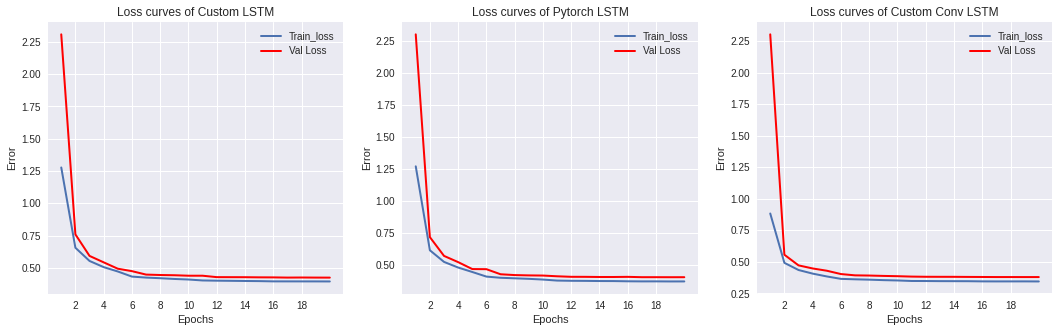

In [108]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,3)
fig.set_size_inches(18, 5)

ax[0].plot(epochs_cuslstm, train_loss_cuslstm, label="Train_loss", linewidth=2)
ax[0].plot(epochs_cuslstm, val_loss_cuslstm, label="Val Loss", c='red', linewidth=2)
ax[0].legend(loc='best')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Error")
ax[0].set_xticks(np.arange(2, 19, step=2))

ax[0].set_title("Loss curves of Custom LSTM")

ax[1].plot(epochs_lstm, train_loss_lstm, label="Train_loss", linewidth=2)
ax[1].plot(epochs_lstm, val_loss_lstm , label="Val Loss", c='red', linewidth=2)
ax[1].legend(loc='best')
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Error")
ax[1].set_xticks(np.arange(2, 19, step=2))

ax[1].set_title("Loss curves of Pytorch LSTM")

ax[2].plot(epochs_conv, train_loss_conv, label="Train_loss", linewidth=2)
ax[2].plot(epochs_conv, val_loss_conv , label="Val Loss", c='red', linewidth=2)
ax[2].legend(loc='best')
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("Error")
ax[2].set_xticks(np.arange(2, 19, step=2))

ax[2].set_title("Loss curves of Custom Conv LSTM")


plt.show()

The curves show that the models have learned quite well and reach a stability point. The custom LSTM model works at par with Pytorchs inbuilt LSTM. However, it takes a little more time to reach stability(very minimal, almost negligible).
The custom Conv LSTM reaches stability before the other models.It is noteworthy to mention that the custom Conv LSTM starts with a significantly lesser training loss value than the other models and the validation loss too is much lower by epoch 2 than the other models.

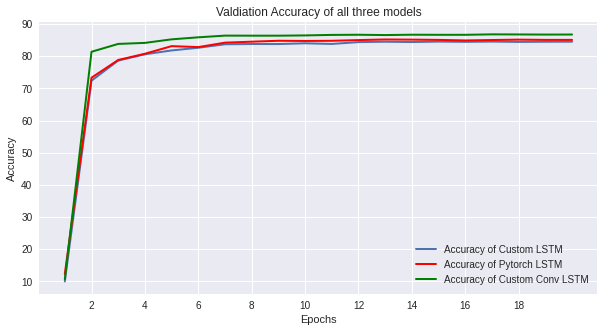

In [109]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10, 5)

ax.plot(epochs_cuslstm, valid_acc_cuslstm, linewidth=2,label="Accuracy of Custom LSTM")
ax.plot(epochs_lstm, valid_acc_lstm, label="Accuracy of Pytorch LSTM",c='red', linewidth=2)
ax.plot(epochs_conv, valid_acc_conv, label="Accuracy of Custom Conv LSTM",c='green', linewidth=2)
ax.legend(loc='best')
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.set_xticks(np.arange(2, 19, step=2))

ax.set_title(f"Valdiation Accuracy of all three models")

plt.show()

Pytorch LSTM model reaches an accuracy of 85.05% while the custom LSTM reaches a maximum accuracy of 84.5%, whereas the custom Conv LSTM model clearly performs better than the other 2 models reaching a maximum accuracy of 86.74%.  

### GRU Implementation

In [110]:
class GRU(nn.Module):

    def __init__(self, in_dim, hidden_dim, bias=True):
        super(GRU, self).__init__()
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.bias = bias
        self.layer1 = nn.Linear(in_dim, 3 * hidden_dim, bias=bias)
        self.layer2 = nn.Linear(hidden_dim, 3 * hidden_dim, bias=bias)
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_dim)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, x, hidden):

        x = x.view(-1, x.size(1))

        gate_x = self.layer1(x) 
        gate_h = self.layer2(hidden)

        gate_x = gate_x.squeeze()
        gate_h = gate_h.squeeze()
        i_r, i_i, i_n = gate_x.chunk(3, 1)
        h_r, h_i, h_n = gate_h.chunk(3, 1)


        reset_gate = torch.sigmoid(i_r + h_r)
        update_gate = torch.sigmoid(i_i + h_i)
        next_gate = torch.tanh(i_n + (reset_gate * h_n))

        h_y = next_gate + update_gate * (hidden - next_gate)

        return h_y

#create GRU model class
class GRUModel(nn.Module):
    def __init__(self, in_dim, emb_dim, hidden_dim, num_layers, out_size, bias=True, mode="zeros"):
        super(GRUModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.mode = mode
        self.encoder = nn.Linear(in_features=in_dim, out_features=emb_dim)
        
        grus = []
        for i in range(num_layers):
            in_size = emb_dim if i == 0 else hidden_dim
            grus.append(GRU(in_dim=in_size, hidden_dim=hidden_dim))
        self.gru = nn.ModuleList(grus)
        
        # classifier
        self.fc = nn.Linear(hidden_dim, out_size)
        
    def init_state(self, b_size, device):
        """ Initializing hidden and cell state """
        if(self.mode == "zeros"):
            h = torch.zeros(self.num_layers,b_size, self.hidden_dim).to(device) 
            c = torch.zeros(self.num_layers,b_size, self.hidden_dim).to(device) 
        elif(self.mode == "random"):
            h = torch.zeros(self.num_layers,b_size, self.hidden_dim).to(device) 
            c = torch.zeros(self.num_layers,b_size, self.hidden_dim).to(device) 
        return h, c
    
    
    def forward(self, x):
        b_size, n_channels, n_rows, n_cols = x.shape
        # Initialize hidden state with zeros
        h, c = self.init_state(b_size=b_size, device=x.device) 
        
        # embedding rows
        x_rowed = x.view(b_size, n_channels*n_rows, n_cols)

        embeddings = self.encoder(x_rowed)
        
        out = []
        for i in range(embeddings.shape[1]):
            gru_input = embeddings[:, i, :]
            # iterating over GRU Cells
            for j, lstm_cell in enumerate(self.gru):
                h[j] = lstm_cell(gru_input, (h[j].clone()))
                gru_input = h[j]
            out.append(gru_input)
        out = torch.stack(out, dim=1)

        # classifying
        y = self.fc(out[:, -1, :])  # feeding only output at last layer
        return y
        

In [111]:
model_GRU = GRUModel(in_dim=28, emb_dim=64, hidden_dim=128, num_layers=1,out_size=10, mode="zeros")
count_model_params(model_GRU)

77642

In [112]:
model_GRU = model_GRU.to(device)
print(model_GRU)

GRUModel(
  (encoder): Linear(in_features=28, out_features=64, bias=True)
  (gru): ModuleList(
    (0): GRU(
      (layer1): Linear(in_features=64, out_features=384, bias=True)
      (layer2): Linear(in_features=128, out_features=384, bias=True)
    )
  )
  (fc): Linear(in_features=128, out_features=10, bias=True)
)


In [113]:
# classification loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model_GRU.parameters(), lr=3e-4)

# Decay LR by a factor of 0.1 every 5 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)

In [114]:
train_loss_gru, val_loss_gru, loss_iters_gru, valid_acc_gru, epochs_gru = train_model(
        model=model_GRU, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=test_loader, num_epochs=20
    )

Epoch 1 Iter 235: loss 1.07821. : 100%|██████████| 235/235 [00:19<00:00, 12.23it/s]


Epoch 1/20
    Train loss: 1.38202
    Valid loss: 2.31353
    Accuracy: 13.34%




Epoch 2 Iter 235: loss 0.62989. : 100%|██████████| 235/235 [00:19<00:00, 11.78it/s]


Epoch 2/20
    Train loss: 0.69364
    Valid loss: 0.81865
    Accuracy: 70.67999999999999%




Epoch 3 Iter 235: loss 0.57170. : 100%|██████████| 235/235 [00:20<00:00, 11.69it/s]


Epoch 3/20
    Train loss: 0.59466
    Valid loss: 0.63111
    Accuracy: 76.46%




Epoch 4 Iter 235: loss 0.49704. : 100%|██████████| 235/235 [00:20<00:00, 11.75it/s]


Epoch 4/20
    Train loss: 0.54428
    Valid loss: 0.57847
    Accuracy: 77.8%




Epoch 5 Iter 235: loss 0.37438. : 100%|██████████| 235/235 [00:19<00:00, 11.96it/s]


Epoch 5/20
    Train loss: 0.50316
    Valid loss: 0.53504
    Accuracy: 79.79%




Epoch 6 Iter 235: loss 0.53830. : 100%|██████████| 235/235 [00:19<00:00, 12.12it/s]


Epoch 6/20
    Train loss: 0.47402
    Valid loss: 0.50014
    Accuracy: 81.28%




Epoch 7 Iter 235: loss 0.29965. : 100%|██████████| 235/235 [00:19<00:00, 12.02it/s]


Epoch 7/20
    Train loss: 0.46673
    Valid loss: 0.4894
    Accuracy: 81.62%




Epoch 8 Iter 235: loss 0.42841. : 100%|██████████| 235/235 [00:19<00:00, 11.96it/s]


Epoch 8/20
    Train loss: 0.46042
    Valid loss: 0.48217
    Accuracy: 82.19999999999999%




Epoch 9 Iter 235: loss 0.35087. : 100%|██████████| 235/235 [00:19<00:00, 12.37it/s]


Epoch 9/20
    Train loss: 0.45402
    Valid loss: 0.47714
    Accuracy: 82.3%




Epoch 10 Iter 235: loss 0.48696. : 100%|██████████| 235/235 [00:19<00:00, 12.34it/s]


Epoch 10/20
    Train loss: 0.44858
    Valid loss: 0.47389
    Accuracy: 82.58%




Epoch 11 Iter 235: loss 0.51551. : 100%|██████████| 235/235 [00:19<00:00, 12.25it/s]


Epoch 11/20
    Train loss: 0.44356
    Valid loss: 0.46671
    Accuracy: 82.64%




Epoch 12 Iter 235: loss 0.54148. : 100%|██████████| 235/235 [00:19<00:00, 11.98it/s]


Epoch 12/20
    Train loss: 0.44234
    Valid loss: 0.46398
    Accuracy: 82.73%




Epoch 13 Iter 235: loss 0.44856. : 100%|██████████| 235/235 [00:19<00:00, 12.35it/s]


Epoch 13/20
    Train loss: 0.44088
    Valid loss: 0.46278
    Accuracy: 82.84%




Epoch 14 Iter 235: loss 0.47555. : 100%|██████████| 235/235 [00:18<00:00, 12.48it/s]


Epoch 14/20
    Train loss: 0.43989
    Valid loss: 0.46192
    Accuracy: 82.94%




Epoch 15 Iter 235: loss 0.65530. : 100%|██████████| 235/235 [00:18<00:00, 12.38it/s]


Epoch 15/20
    Train loss: 0.43924
    Valid loss: 0.46036
    Accuracy: 82.89%




Epoch 16 Iter 235: loss 0.41423. : 100%|██████████| 235/235 [00:19<00:00, 12.35it/s]


Epoch 16/20
    Train loss: 0.43759
    Valid loss: 0.45965
    Accuracy: 83.1%




Epoch 17 Iter 235: loss 0.35504. : 100%|██████████| 235/235 [00:18<00:00, 12.53it/s]


Epoch 17/20
    Train loss: 0.43716
    Valid loss: 0.45913
    Accuracy: 82.94%




Epoch 18 Iter 235: loss 0.31895. : 100%|██████████| 235/235 [00:18<00:00, 12.50it/s]


Epoch 18/20
    Train loss: 0.43685
    Valid loss: 0.45892
    Accuracy: 82.93%




Epoch 19 Iter 235: loss 0.28903. : 100%|██████████| 235/235 [00:19<00:00, 12.26it/s]


Epoch 19/20
    Train loss: 0.43653
    Valid loss: 0.45873
    Accuracy: 82.91%




Epoch 20 Iter 235: loss 0.32383. : 100%|██████████| 235/235 [00:18<00:00, 12.42it/s]

Epoch 20/20
    Train loss: 0.43642
    Valid loss: 0.45847
    Accuracy: 82.93%


Training completed


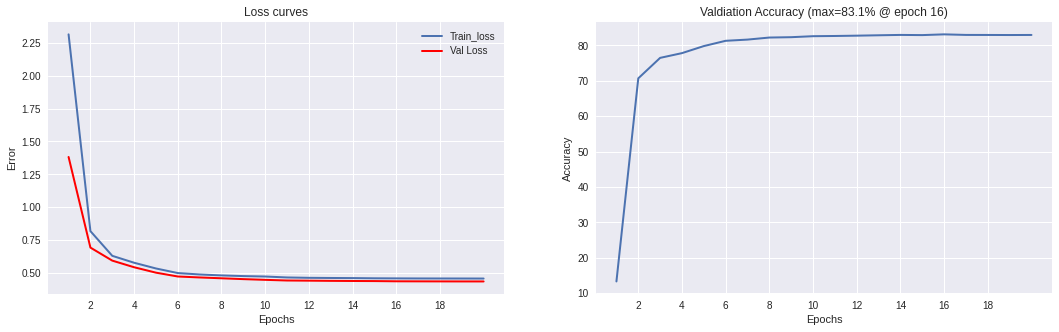

In [115]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,2)
fig.set_size_inches(18, 5)

ax[0].plot(epochs_gru, val_loss_gru, label="Train_loss", linewidth=2)
ax[0].plot(epochs_gru, train_loss_gru, label="Val Loss", c='red', linewidth=2)
ax[0].legend(loc='best')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Error")
ax[0].set_xticks(np.arange(2, 19, step=2))

ax[0].set_title("Loss curves")


ax[1].plot(epochs_gru, valid_acc_gru, label="Accuracy", linewidth=2)
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].set_xticks(np.arange(2, 19, step=2))

ax[1].set_title(f"Valdiation Accuracy (max={round(np.max(valid_acc_gru),2)}% @ epoch {np.argmax(valid_acc_gru)+1})")

plt.show()

The GRU model reaches stability almost at the same time as the custom conv lstm model. The maximum accuracy of the GRU model is less than all the other models at 83.1%, but is close to the accuracy of LSTM and Custom LSTM.

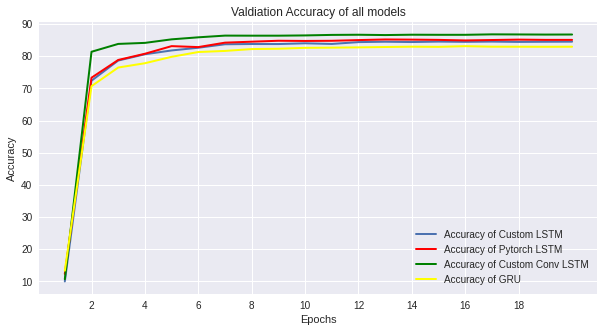

In [132]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10, 5)

ax.plot(epochs_cuslstm, valid_acc_cuslstm, linewidth=2,label="Accuracy of Custom LSTM")
ax.plot(epochs_lstm, valid_acc_lstm, label="Accuracy of Pytorch LSTM",c='red', linewidth=2)
ax.plot(epochs_conv, valid_acc_conv, label="Accuracy of Custom Conv LSTM",c='green', linewidth=2)
ax.plot(epochs_gru, valid_acc_gru, label="Accuracy of GRU",c='yellow', linewidth=2)
ax.legend(loc='best')
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.set_xticks(np.arange(2, 19, step=2))

ax.set_title(f"Valdiation Accuracy of all models")

plt.show()

Model trained with GRU achieves almost the same results as the model trained using Pytorchs LSTM. The models that have reached better accuracy in order of highest are: Custom Conv LSTM, Pytorch LSTM, Custom LSTM, GRU.

## References
https://towardsdatascience.com/building-a-lstm-by-hand-on-pytorch-59c02a4ec091

https://paperswithcode.com/method/convlstm

https://arxiv.org/abs/1506.04214v2

https://medium.com/neuronio/an-introduction-to-convlstm-55c9025563a7